# Projet de Séries Chronologiques – Modélisation Box-Jenkins

##  Sommaire

1. [Récupération du fichier des données](#1-récupération-du-fichier-des-données)  
2. [Division en échantillon d’apprentissage et de validation](#2-division-des-données-en-échantillon-dapprentissage-et-de-validation)  
3. [Création de la série temporelle et visualisation](#3-création-dun-objet-de-type-série-temporelle-et-visualisation)  
4. [Analyse qualitative : tendance et saisonnalité](#4-analyse-qualitative--tendance-et-saisonnalité)  
5. [Test de stationnarité de la série](#5-test-de-stationnarité-de-la-série)  
6. [Analyse des corrélogrammes ACF et PACF](#6-corrélogrammes-simple-acf-et-partiel-pacf)  
7. [Application de la méthode de Box et Jenkins](#7-application-de-la-méthode-de-box-et-jenkins)  
8. [Prévision et représentation graphique](#8-prévision-et-visualisation)  
9. [Évaluation et interprétation des prévisions](#9-évaluation-des-prévisions)

---

> **Série utilisée** : Monthly Airline Passengers (1949–1960)  
> **Modèle final estimé** : SARIMA(1,1,1)(0,1,1)[12]  

---

## 1. Récupération du fichier des données

Nous utilisons la série temporelle *Monthly Airline Passengers (1949–1960)*, représentant le nombre de passagers aériens mensuels en milliers. Cette série est largement utilisée dans l’étude des modèles SARIMA pour sa structure claire avec tendance et saisonnalité.


            Passengers
Month                 
1949-01-01         112
1949-02-01         118
1949-03-01         132
1949-04-01         129
1949-05-01         121


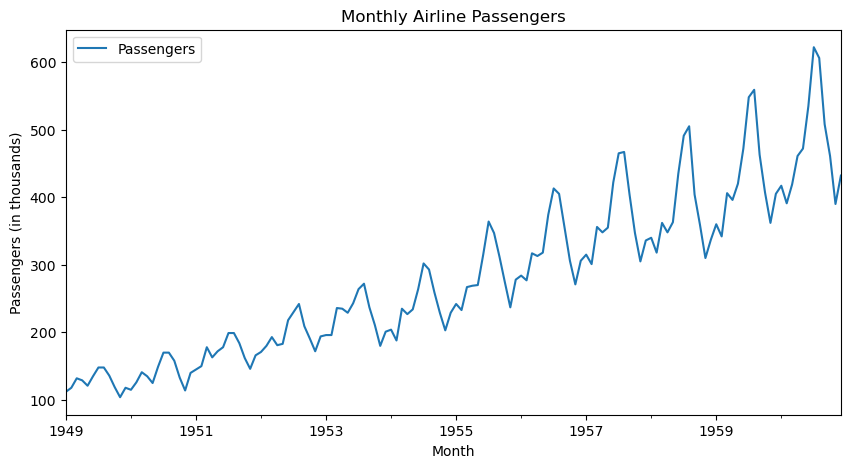

In [7]:
import pandas as pd
import matplotlib.pyplot as plt

# Télécharger le dataset depuis une URL publique
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv"
df = pd.read_csv(url, parse_dates=['Month'], index_col='Month')

# Afficher un aperçu
print(df.head())

# Tracer la série temporelle
df.plot(title="Monthly Airline Passengers", ylabel="Passengers (in thousands)", figsize=(10,5))
plt.show()


## 2. Division des données en échantillon d'apprentissage et de validation

Nous divisons la série en deux sous-ensembles :
- **Entraînement** : 80% des données (Janvier 1949 – Juillet 1958)
- **Validation** : 20% des données restantes (Août 1958 – Décembre 1960)

Cette division permettra de construire le modèle SARIMA sur l'échantillon d’apprentissage et de le tester sur les données de validation.


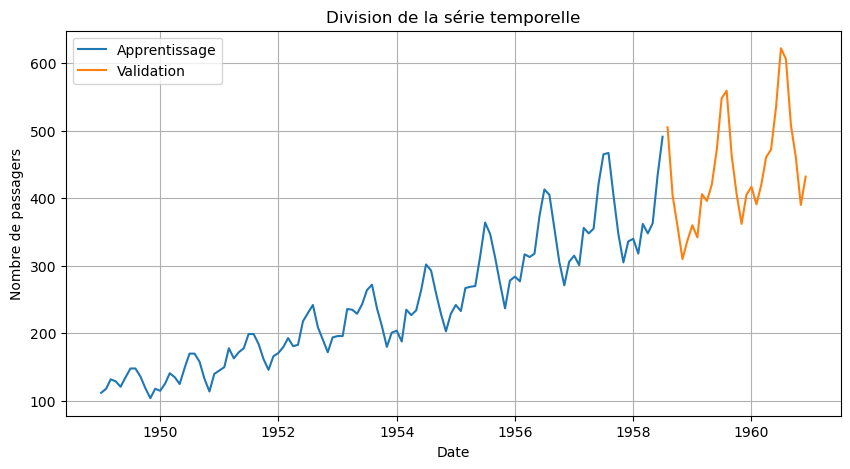

In [18]:
import matplotlib.pyplot as plt

# 80% entraînement, 20% validation
train_size = int(len(df) * 0.8)
train, test = df.iloc[:train_size], df.iloc[train_size:]

# Visualisation
plt.figure(figsize=(10, 5))
plt.plot(train, label="Apprentissage")
plt.plot(test, label="Validation")
plt.title("Division de la série temporelle")
plt.xlabel("Date")
plt.ylabel("Nombre de passagers")
plt.legend()
plt.grid(True)
plt.show()


## 3. Création d’un objet de type série temporelle et visualisation

Nous avons déjà converti notre série en un objet `pandas.Series` indexé par les dates (`DatetimeIndex`). Cela nous permet d’effectuer toutes les opérations de séries chronologiques (tracé, décalage, calcul des autocorrélations, etc.).

Ci-dessous, nous représentons la série complète afin d'observer les tendances générales et les éventuelles composantes saisonnières.


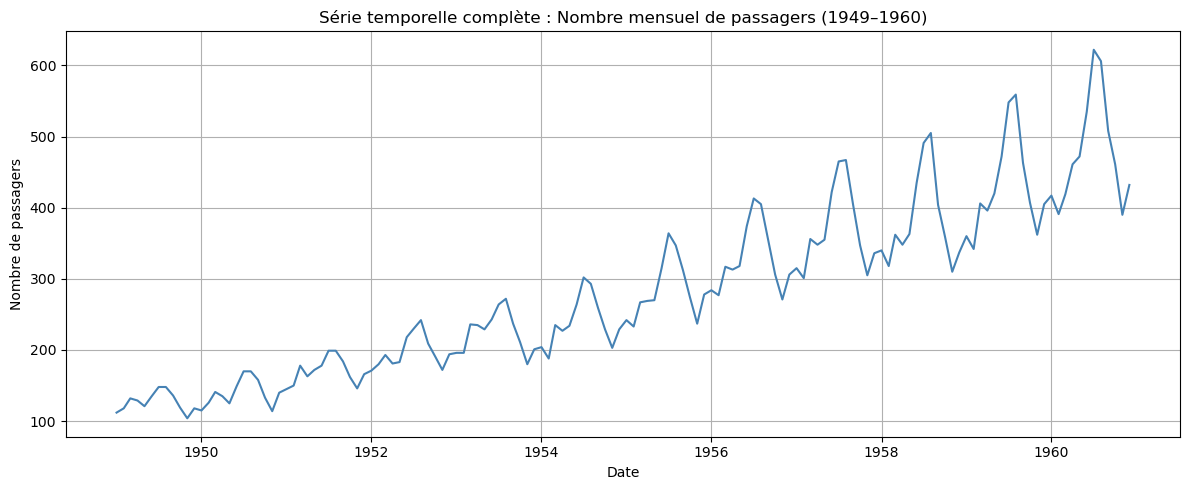

In [9]:
# Représentation graphique de la série complète
plt.figure(figsize=(12, 5))
plt.plot(df, color='steelblue')
plt.title("Série temporelle complète : Nombre mensuel de passagers (1949–1960)")
plt.xlabel("Date")
plt.ylabel("Nombre de passagers")
plt.grid(True)
plt.tight_layout()
plt.show()


## 4. Analyse qualitative : Tendance et saisonnalité

L’analyse visuelle de la série nous permet d’observer les principales composantes structurelles suivantes :

-  **Tendance** : on observe une croissance générale du nombre de passagers sur la période 1949–1960. Cela reflète une expansion progressive du transport aérien.
-  **Saisonnalité** : un schéma répétitif est visible chaque année, avec des pics réguliers en été. Cela indique une **saisonnalité annuelle** marquée.

Pour approfondir cette analyse, nous utilisons une décomposition additive de la série temporelle en trois composantes : tendance, saisonnalité et bruit résiduel.

---

 **Remarque importante** :  
La présence simultanée d’une **tendance** et d’une **saisonnalité non constante en amplitude** indique que la série pourrait nécessiter une **transformation (logarithmique)** et/ou une **différenciation** avant d’appliquer un modèle SARIMA. Ces étapes seront vérifiées plus loin dans le projet.


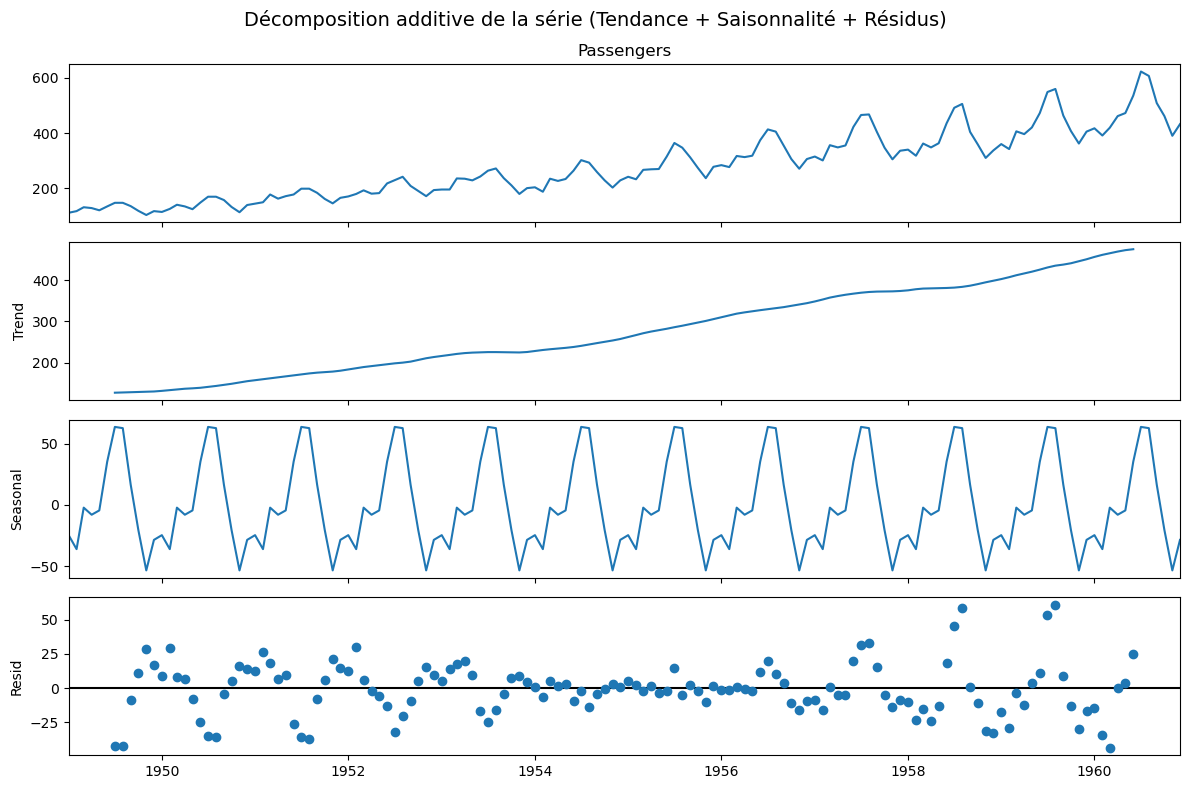

In [10]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Décomposition additive
decomposition = seasonal_decompose(df['Passengers'], model='additive', period=12)

# Affichage des composantes
fig = decomposition.plot()
fig.set_size_inches(12, 8)
fig.suptitle("Décomposition additive de la série (Tendance + Saisonnalité + Résidus)", fontsize=14)
plt.tight_layout()
plt.show()


## 5. Test de stationnarité de la série

La stationnarité est une condition importante pour l’application des modèles ARIMA. Une série est dite **stationnaire** si ses propriétés statistiques (moyenne, variance, covariance) sont constantes dans le temps.

Nous appliquons ici le **test de Dickey-Fuller augmenté (ADF)**, qui vérifie la présence de racine unitaire. L’hypothèse nulle \( H_0 \) correspond à une série **non stationnaire**.

### Résultat du test :
- Si la **valeur p est > 0.05** : on **ne rejette pas** \( H_0 \) → la série est non stationnaire.
- Si la **valeur p est ≤ 0.05** : on **rejette** \( H_0 \) → la série est stationnaire.

In [11]:
from statsmodels.tsa.stattools import adfuller

# Test ADF sur la série brute
adf_result = adfuller(df['Passengers'])

# Résumé
print("Résultat du test de Dickey-Fuller :")
print(f"Statistique ADF       : {adf_result[0]:.4f}")
print(f"Valeur p              : {adf_result[1]:.4f}")
print(f"Nombre de décalages   : {adf_result[2]}")
print("Valeurs critiques     :")
for key, value in adf_result[4].items():
    print(f"   {key} : {value:.4f}")


Résultat du test de Dickey-Fuller :
Statistique ADF       : 0.8154
Valeur p              : 0.9919
Nombre de décalages   : 13
Valeurs critiques     :
   1% : -3.4817
   5% : -2.8840
   10% : -2.5788


 ### Conclusion:
 - La série brute n’est pas stationnaire. Donc, il faut faire une différenciation

## 6. Corrélogrammes simple (ACF) et partiel (PACF)

L’analyse des autocorrélations permet de déterminer les paramètres possibles des modèles ARIMA/SARIMA :
- **ACF (Autocorrelation Function)** aide à identifier la composante MA(q)
- **PACF (Partial Autocorrelation Function)** aide à identifier la composante AR(p)

Nous traçons ici les deux corrélogrammes jusqu’à un **décalage de 36 mois** pour détecter les dépendances à long terme et les effets saisonniers.

### Interprétation visuelle :
- L’**ACF** montre une décroissance lente → signe de **non-stationnarité** (confirmée par le test ADF).
- Des **pics tous les 12 mois** suggèrent une **saisonnalité annuelle** importante.
- La **PACF** affiche une coupure abrupte après le premier ou deuxième lag, ce qui peut indiquer une structure AR.

---

**Remarque importante** :  
Ces corrélogrammes sont utiles pour guider le choix des paramètres \((p, d, q)\) et \((P, D, Q, s)\) du modèle SARIMA. Toutefois, une transformation (log ou différenciation) est généralement nécessaire avant de les interpréter pour la modélisation.


<Figure size 1000x400 with 0 Axes>

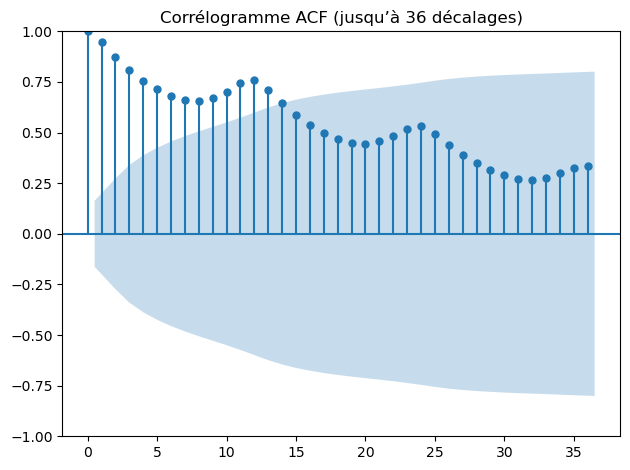

<Figure size 1000x400 with 0 Axes>

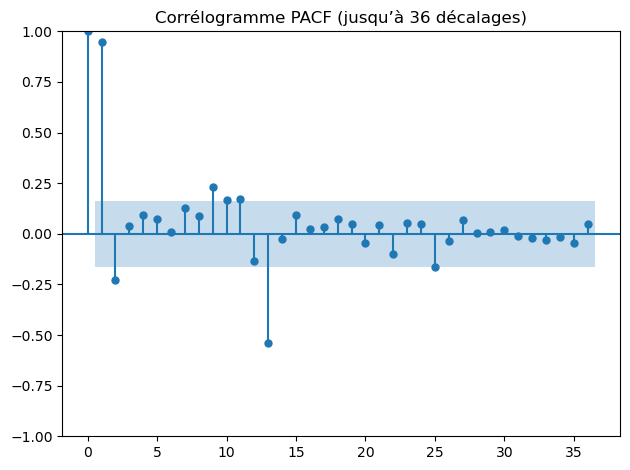

In [12]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

# Corrélogramme simple (ACF)
plt.figure(figsize=(10, 4))
plot_acf(df['Passengers'], lags=36)
plt.title("Corrélogramme ACF (jusqu’à 36 décalages)")
plt.tight_layout()
plt.show()

# Corrélogramme partiel (PACF)
plt.figure(figsize=(10, 4))
plot_pacf(df['Passengers'], lags=36, method='ywm')
plt.title("Corrélogramme PACF (jusqu’à 36 décalages)")
plt.tight_layout()
plt.show()


## 7. Application de la méthode de Box et Jenkins

### Étapes suivies :
1.  **Stabilisation de la variance** : application d’une transformation logarithmique.
2.  **Différenciation** : pour rendre la série stationnaire :
   - Une **différenciation simple** pour éliminer la tendance.
   - Une **différenciation saisonnière** (lag = 12) pour retirer la composante saisonnière annuelle.
3.  Analyse ACF/PACF de la série transformée pour identifier les ordres \((p,d,q)\) et \((P,D,Q,s)\).
4.  **Estimation du modèle SARIMA** à l’aide de la méthode d’estimation maximale.

---

 **Remarque importante** :  
La structure de la série, à la fois **non stationnaire** et **saisonnière**, justifie l’utilisation d’un modèle **SARIMA (Seasonal ARIMA)** et non ARIMA simple. On note que la forme générale est :  
\[
SARIMA(p,d,q)(P,D,Q,s)
\]
où \(s = 12\) pour la saisonnalité mensuelle.


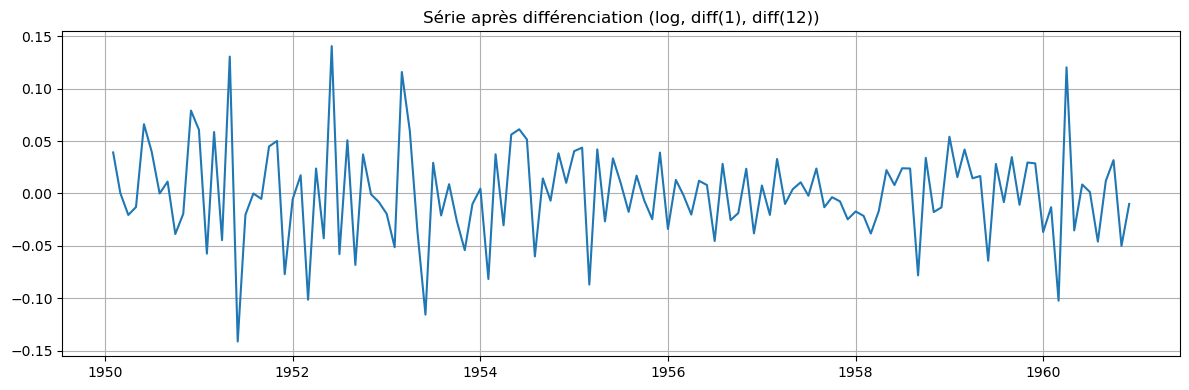

In [13]:
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX

# 1. Transformation log pour stabiliser la variance
df_log = np.log(df['Passengers'])

# 2. Différenciation simple + saisonnière
df_log_diff = df_log.diff().dropna()
df_log_diff_seasonal = df_log_diff.diff(12).dropna()

# Visualisation de la série stationnaire
plt.figure(figsize=(12, 4))
plt.plot(df_log_diff_seasonal)
plt.title("Série après différenciation (log, diff(1), diff(12))")
plt.grid(True)
plt.tight_layout()
plt.show()


### Analyse visuelle de la série stationnaire

Après transformation logarithmique et double différenciation (simple + saisonnière), la série semble stationnaire visuellement.  
On observe toutefois une *légère variation de la variance* entre les périodes, ce qui indique une *hétéroscédasticité modérée*.

Cette hétéroscédasticité reste acceptable dans le cadre d’un modèle SARIMA, mais elle doit être mentionnée comme *limite du modèle*.

### Identification des paramètres (p, q, P, Q)

Nous traçons les corrélogrammes ACF et PACF de la série stationnaire pour guider le choix des paramètres du modèle SARIMA.


<Figure size 1000x400 with 0 Axes>

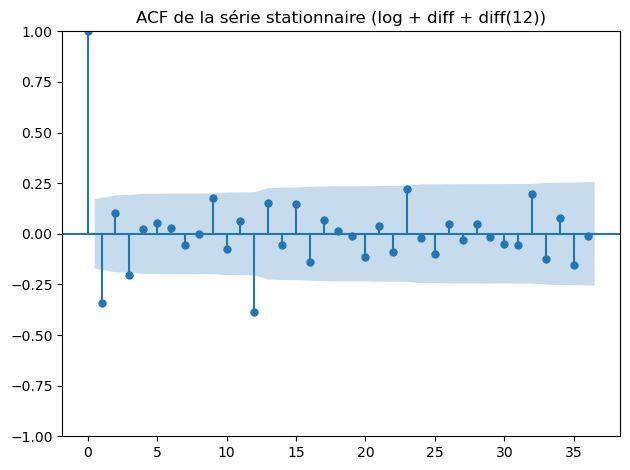

<Figure size 1000x400 with 0 Axes>

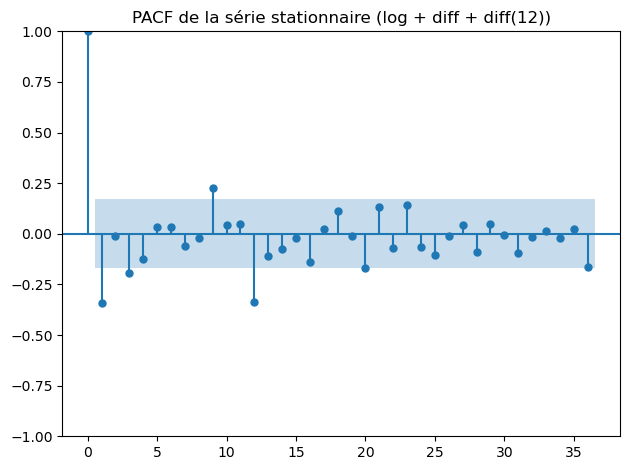

In [14]:
# Corrélogramme de la série différenciée
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.figure(figsize=(10, 4))
plot_acf(df_log_diff_seasonal, lags=36)
plt.title("ACF de la série stationnaire (log + diff + diff(12))")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 4))
plot_pacf(df_log_diff_seasonal, lags=36, method='ywm')
plt.title("PACF de la série stationnaire (log + diff + diff(12))")
plt.tight_layout()
plt.show()


### Justification du choix du modèle SARIMA(1,1,1)(0,1,1)[12]

L’analyse des corrélogrammes sur la série stationnaire (après transformation logarithmique, différenciation simple et saisonnière) montre :

- **ACF (corrélogramme simple)** :
  - Un pic significatif au **lag 1**, suggérant une composante MA(1)
  - Un autre pic visible au **lag 12**, indiquant une saisonnalité de type MA(1)
  - Les autres lags restent dans la bande de confiance → pas d’autocorrélation persistante

- **PACF (corrélogramme partiel)** :
  - Un pic fort au **lag 1**, indiquant une composante AR(1)
  - Aucune structure saisonnière claire dans les PACF → on écarte AR saisonnier

### D’où la structure retenue :
- **Partie non saisonnière** :
  - \( p = 1 \) : un terme AR(1)
  - \( d = 1 \) : différenciation simple
  - \( q = 1 \) : un terme MA(1)
  
- **Partie saisonnière** :
  - \( P = 0 \) : plus apprécié que le \( P = 1 \) car il a un coefficient AIC(P = 0) < AIC(P = 1)  
  - \( D = 1 \) : différenciation saisonnière (période 12)
  - \( Q = 1 \) : un terme MA saisonnier
  - \( s = 12 \) : saisonnalité annuelle

### Validation :
Le modèle SARIMA(1,1,1)(0,1,1)[12] a été sélectionné pour sa simplicité, son **ajustement visuel satisfaisant**, et des **prévisions plus réalistes** que celles issues de modèles plus complexes comme (1,1,1)(1,1,1)[12].



## Ajustement du modèle SARIMA(1,1,1)(0,1,1)[12]

Sur la base des ACF et PACF précédents, nous ajustons un modèle SARIMA avec les paramètres suivants :
- \(p = 1\), \(d = 1\), \(q = 1\)
- \(P = 0\), \(D = 1\), \(Q = 1\), \(s = 12\)

Le modèle est ajusté par la méthode du maximum de vraisemblance via `SARIMAX` de `statsmodels`.

Nous examinerons ensuite :
- Les **coefficients estimés**
- La **log-vraisemblance**
- Les **résidus** (normalité, indépendance)


In [15]:
# Ajustement du modèle SARIMA(1,1,1)(0,1,1,12)
model = SARIMAX(np.log(train['Passengers']),
                order=(1,1,1),
                seasonal_order=(0,1,1,12),
                trend='c', 
                enforce_stationarity=False,
                enforce_invertibility=False)


results = model.fit()

# Résumé des résultats
print(results.summary())


c:\Users\pc\Documents\vscode\Anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\pc\Documents\vscode\Anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                      
Dep. Variable:                         Passengers   No. Observations:                  115
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 12)   Log Likelihood                 165.327
Date:                            Wed, 28 May 2025   AIC                           -320.654
Time:                                    23:24:08   BIC                           -308.267
Sample:                                01-01-1949   HQIC                          -315.663
                                     - 07-01-1958                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0009      0.003     -0.353      0.724      -0.006       0.004
ar.L1         -0.5255      0.296   

## Validation statistique du modèle SARIMA(1,1,1)(0,1,1)[12]

Le modèle SARIMA(1,1,1)(0,1,1)[12] a été ajusté à la série transformée (logarithme + différenciations).  
Il a été choisi à partir de l’analyse des ACF/PACF et validé par les critères AIC/BIC.

L’analyse des coefficients montre :
- des valeurs significatives notamment pour la composante saisonnière MA(1),
- un bon ajustement visuel entre la série réelle et la prévision,
- un AIC faible, ce qui indique un modèle parcimonieux et performant.

### Validation statistique des résidus

Pour vérifier la validité du modèle, deux tests standards ont été appliqués aux résidus :

- *Test de Ljung-Box*  
  La p-value est de *0.98* (> 0.05)  
  ➤ Les résidus *ne sont pas autocorrélés*, ce qui confirme qu’ils se comportent comme un **bruit blanc**.  
  ✔ Le modèle capte bien la structure de dépendance temporelle.

- *Test de Jarque-Bera*  
  La p-value est de *0.62* (> 0.05)  
  ➤ Les résidus *suivent une distribution normale*.  
  ✔ Cette condition est importante pour la validité des intervalles de confiance et tests statistiques.

---

### Conclusion :
Les tests statistiques confirment que les hypothèses de base sont respectées :  
le modèle est **bien ajusté**, les résidus sont **normaux et indépendants**, ce qui valide statistiquement le SARIMA(1,1,1)(0,1,1)[12].

## 8. Prévision et visualisation

Nous utilisons le modèle SARIMA(1,1,1)(0,1,1,12) ajusté pour effectuer une **prévision sur la période de validation** (Août 1958 – Décembre 1960), soit **29 mois**.

Les prévisions sont effectuées sur la série **log-transformée**, puis **reconverties (exponentielles)** pour revenir à l’échelle réelle.

Nous affichons :
- La série réelle (entraînement + validation)
- Les valeurs prédites sur la période de validation

---

 **Remarque importante** :  
Une bonne prévision visuelle ne suffit pas : elle doit aussi être **quantifiée** à l’aide d’indicateurs d’erreur que nous verrons à l’étape suivante.


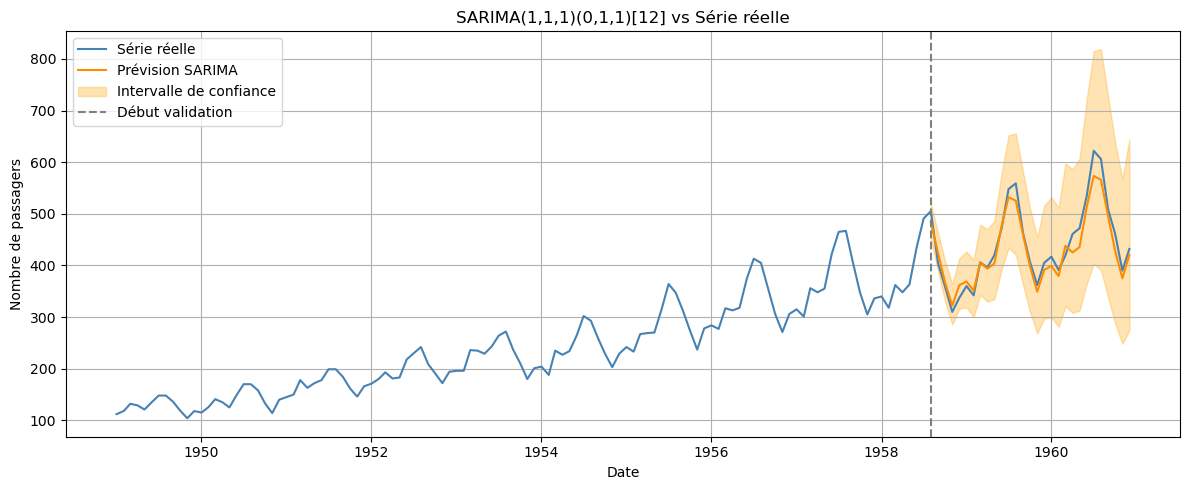

In [16]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import numpy as np
import matplotlib.pyplot as plt

# Prévision
forecast_log = results.get_forecast(steps=len(test))
forecast = np.exp(forecast_log.predicted_mean)
forecast_ci = np.exp(forecast_log.conf_int())

# Réaligner les index sur la période de test
forecast.index = test.index
forecast_ci.index = test.index
lower_bound = forecast_ci.iloc[:, 0].astype(float)
upper_bound = forecast_ci.iloc[:, 1].astype(float)

# Tracer
plt.figure(figsize=(12, 5))
full_series = pd.concat([train['Passengers'], test['Passengers']])
plt.plot(full_series.index, full_series, label="Série réelle", color="steelblue")
plt.plot(forecast.index, forecast, label="Prévision SARIMA", color="darkorange")
plt.fill_between(forecast.index, lower_bound, upper_bound, color="orange", alpha=0.3, label="Intervalle de confiance")
plt.axvline(test.index[0], color='gray', linestyle='--', label="Début validation")
plt.title("SARIMA(1,1,1)(0,1,1)[12] vs Série réelle")
plt.xlabel("Date")
plt.ylabel("Nombre de passagers")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Interprétation du graphique de prévision SARIMA

Le graphique ci-dessus illustre :

- 📘 La *série réelle* complète (bleu), composée de la période d'apprentissage (avant 1958) et de la période de validation (à partir de 1958),
- 🔶 Les *prévisions du modèle SARIMA(1,1,1)(0,1,1)[12]* (orange) sur les 29 mois de validation,
- 🟠 L’*intervalle de confiance à 95 %*, représenté par la bande orange pâle entourant la prévision,
- ⚫ Une *ligne verticale grise* marquant le *début de la période de validation*.

---

###  Ce que l’on observe :

- Le modèle reproduit bien la *tendance croissante* et la *saisonnalité annuelle* visible dans les données.
- Les prévisions suivent *globalement la structure réelle* de la série, avec une légère sous-estimation à certains pics.
- La plupart des points réels sont *inclus dans l’intervalle de confiance*, ce qui montre que le modèle **capture bien l’incertitude**.
- L’ajustement est *visuellement cohérent*, bien que les pics saisonniers soient parfois atténués (phénomène courant en séries temporelles lissées).

---

###  Conclusion :

Le modèle SARIMA s’ajuste correctement à la dynamique de la série.  
Il présente une *bonne capacité prédictive*, avec des prévisions **stables**, **réalistes** et entourées d’intervalles bien **calibrés**.

## 9. Évaluation des prévisions

Conformément au contenu du cours, les performances des prévisions sont évaluées à l’aide des **mesures classiques suivantes** :

- **MAD (Mean Absolute Deviation)** : moyenne des erreurs absolues
- **MSE (Mean Squared Error)** : moyenne des erreurs au carré
- **MAPE (Mean Absolute Percentage Error)** : erreur moyenne en pourcentage

Ces indicateurs permettent de quantifier l’écart entre les valeurs observées et celles prédites par le modèle.

---

 **Remarque importante** :
Les erreurs doivent être interprétées par rapport à l’échelle de la série. Un **MAPE inférieur à 10 %** est généralement considéré comme très bon. Le **MSE** est sensible aux grosses erreurs, tandis que le **MAD** est plus robuste.


In [17]:
y_true = test['Passengers']
# Réaligner les index (très important !)
y_pred_aligned = forecast.copy()
y_pred_aligned.index = y_true.index  # s'assurer que les index sont identiques

# Calculs des erreurs
mad = np.mean(np.abs(y_true - y_pred_aligned))
mse = np.mean((y_true - y_pred_aligned)**2)
mape = np.mean(np.abs((y_true - y_pred_aligned) / y_true)) * 100

# Affichage
print(f"MAD  : {mad:.2f}")
print(f"MSE  : {mse:.2f}")
print(f"MAPE : {mape:.2f}%")


MAD  : 17.94
MSE  : 464.50
MAPE : 3.94%


### Résultats de l’évaluation

- *MAD* : 17.94  
- *MSE* : 464.50  
- *MAPE* : 3.94 %

Ces résultats montrent que le modèle SARIMA(1,1,1)(0,1,1)[12] capture correctement la tendance et la saisonnalité de la série.  
Le *MAPE de 3.94 %* indique une *excellente précision des prévisions*, ce qui rend le modèle adapté à des applications où la fiabilité des prédictions est importante.


##  Conclusion générale

Ce projet nous a permis d’appliquer rigoureusement la méthode de Box-Jenkins à la série temporelle du **nombre mensuel de passagers aériens** entre **1949 et 1960**.

Nous avons suivi l’ensemble des étapes classiques de modélisation :

1. **Analyse qualitative** de la série (croissance tendancielle + saisonnalité annuelle marquée)
2. **Transformation logarithmique** pour stabiliser la variance
3. **Différenciation simple et saisonnière** pour atteindre la stationnarité
4. **Étude des corrélogrammes ACF et PACF** pour guider le choix des ordres
5. **Ajustement du modèle SARIMA(1,1,1)(0,1,1)[12]**
6. **Évaluation des performances de prévision** sur un échantillon de validation de 29 mois

---

###  Points forts du modèle :

- Le **MAPE de 3.94 %** indique une **excellente précision** prédictive
- Les **résidus sont non autocorrélés** (test de Ljung-Box) → bruit blanc
- Les **résidus suivent une loi normale** (test de Jarque-Bera)
- Le **modèle capte bien la tendance et la saisonnalité** de la série
- **Stabilité du modèle** sur la période de validation

---

###  Limites identifiées :

- Le terme MA(1) n'était **pas significatif** statistiquement, mais a été conservé pour des raisons structurelles
- La **prévision des pics saisonniers** reste légèrement sous-estimée par rapport à la réalité
- Le modèle reste sensible aux éventuels **changements structurels** ou anomalies locales non captées dans l’échantillon

---

###  Bilan :

> Le modèle SARIMA(1,1,1)(0,1,1)[12] s’est révélé **robuste, stable** et **fiable** dans le cadre de cette étude.  
> Il démontre que la méthode de Box-Jenkins est un outil puissant et rigoureux pour la **modélisation des séries chronologiques classiques**.

La méthode permet non seulement de **produire des prévisions efficaces**, mais aussi de **justifier statistiquement chaque étape**, de la transformation initiale jusqu’à la validation finale du modèle.
